In [55]:
import spacy
from spacy import displacy
from spacy.matcher import Matcher

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

/home/mangy007/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [4]:
nlp = spacy.load('en_core_web_sm')

/home/mangy007/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 176 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [33]:
# text = 'Usain St Leo Bolt, OJ, CD is a Jamaican former sprinter. He is a world record holder in the 100 metres, 200 metres and 4 × 100 metres relay. Owing to his achievements and dominance in sprint competition, he is widely considered to be the greatest sprinter of all time.'
text = '''Usain Bolt says he 'is ready' to play in the NFL if the Patriots or Packers' quarterback Aaron Rodgers ever came calling. 

The Olympic sprint champion, 33, told TMZ he would consider taking up American football for the right team after he tied the quickest ever NFL 40-yard dash with no warm-up and wearing tracksuit and trainers. 

When probed what it would take for him to play Bolt replied: 'If the Patriots or Aaron Rodgers call me. If they call me, I'm ready.'

The eight-time Olympic gold medalist is also confident about his chances of success, saying 'of course' when asked if he would win a championship with the Patriots.'''

In [34]:
doc = nlp(text)

In [35]:
def get_entities(sent):
    ent1 = ''
    ent2 = ''

    prev_tok_dep = ''
    prev_tok_text = ''

    prefix = ''
    modifier = ''
    
    for token in sent:
        if token.dep_ != 'punct':
            if token.dep_ == 'compound':
                prefix = token.text
                if prev_tok_dep == "compound":
                    prefix = prev_tok_text + " "+ token.text
            if token.dep_.endswith("mod") == True:
                modifier = token.text
                if prev_tok_dep == "compound":
                    modifier = prev_tok_text + " "+ token.text
            if token.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ token.text
                prefix = ""
                modifier = ""
                prev_tok_dep = ""
                prev_tok_text = ""
            if token.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ token.text

            prev_tok_dep = token.dep_
            prev_tok_text = token.text
            
    return [ent1.strip(), ent2.strip()]

In [37]:
for sent in doc.sents:
    for token in sent:
        print(token.text,'-',token.dep_)

Usain - compound
Bolt - nsubj
says - ROOT
he - nsubj
' - punct
is - ccomp
ready - acomp
' - punct
to - aux
play - xcomp
in - prep
the - det
NFL - pobj
if - mark
the - det
Patriots - poss
or - cc
Packers - conj
' - case
quarterback - nsubj
Aaron - compound
Rodgers - appos
ever - advmod
came - advcl
calling - xcomp
. - punct


 - 
The - det
Olympic - amod
sprint - compound
champion - nsubj
, - punct
33 - appos
, - punct
told - ROOT
TMZ - dobj
he - nsubj
would - aux
consider - ccomp
taking - xcomp
up - prt
American - amod
football - dobj
for - prep
the - det
right - amod
team - pobj
after - mark
he - nsubj
tied - advcl
the - det
quickest - amod
ever - advmod
NFL - nmod
40-yard - nummod
dash - dobj
with - prep
no - det
warm - compound
- - punct
up - pobj
and - cc
wearing - conj
tracksuit - dobj
and - cc
trainers - conj
. - punct


 - 
When - advmod
probed - advcl
what - dobj
it - nsubj
would - aux
take - ccomp
for - mark
him - nsubj
to - aux
play - advcl
Bolt - dobj
replied - ROOT
: - punc

In [42]:
def get_relation(sent):
    matcher = Matcher(nlp.vocab)
    doc = nlp(sent)
    pattern = [{'DEP':'ROOT'},
               {'DEP':'prep','OP':'?'},
               {'DEP':'agent','OP':'?'},
               {'POS':'ADJ','OP':'?'}]
    matcher.add('pattern_1',None,pattern)
    matches = matcher(doc)
    span = doc[matches[0][1]:matches[0][2]]
    return span.text

In [44]:
source = []
target = []
relation = []
for sent in doc.sents:
    x,y = get_entities(sent)
    z = get_relation(sent.text)
    source.append(x)
    target.append(y)
    relation.append(z)

In [56]:
kg_df = pd.DataFrame({'source':source,'target':target,'edge':relation})

In [57]:
G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

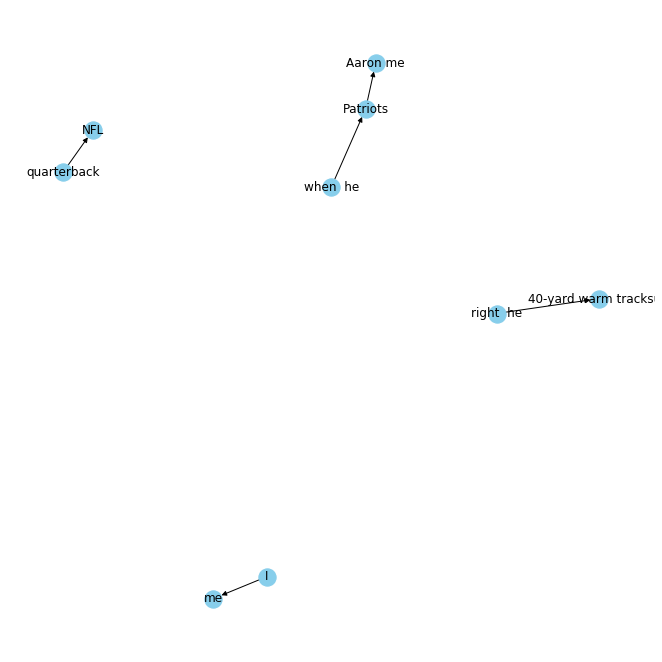

In [62]:
plt.figure(figsize=(9,9))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

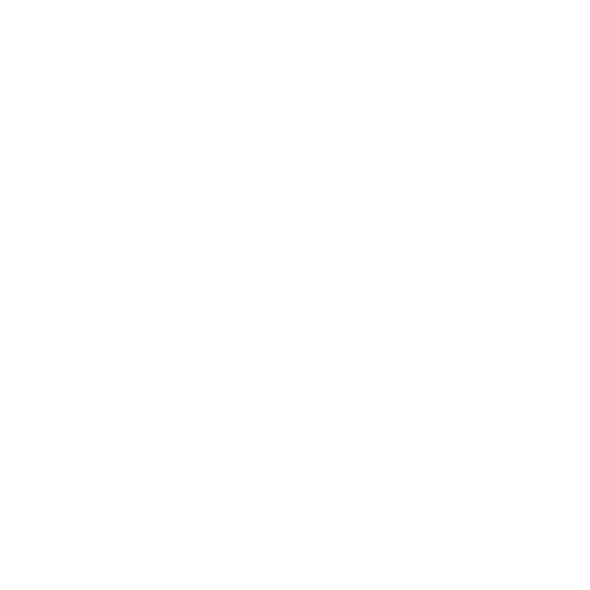

In [65]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="call"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()